In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

import keras
from tqdm import tqdm
import os

def printmd(string):
    display(Markdown(string))

In [2]:
image_dir = Path('C:/Users/User/project_final/colored_images')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head(3)

,Filepath,Label
0,C:\Users\User\project_final\colored_images\Pro...,Proliferate_DR
1,C:\Users\User\project_final\colored_images\Mod...,Moderate
2,C:\Users\User\project_final\colored_images\Mil...,Mild


In [4]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop=True)

In [5]:
# Define the function to apply CLAHE
def apply_clahe(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1 = clahe.apply(img)
    return cl1

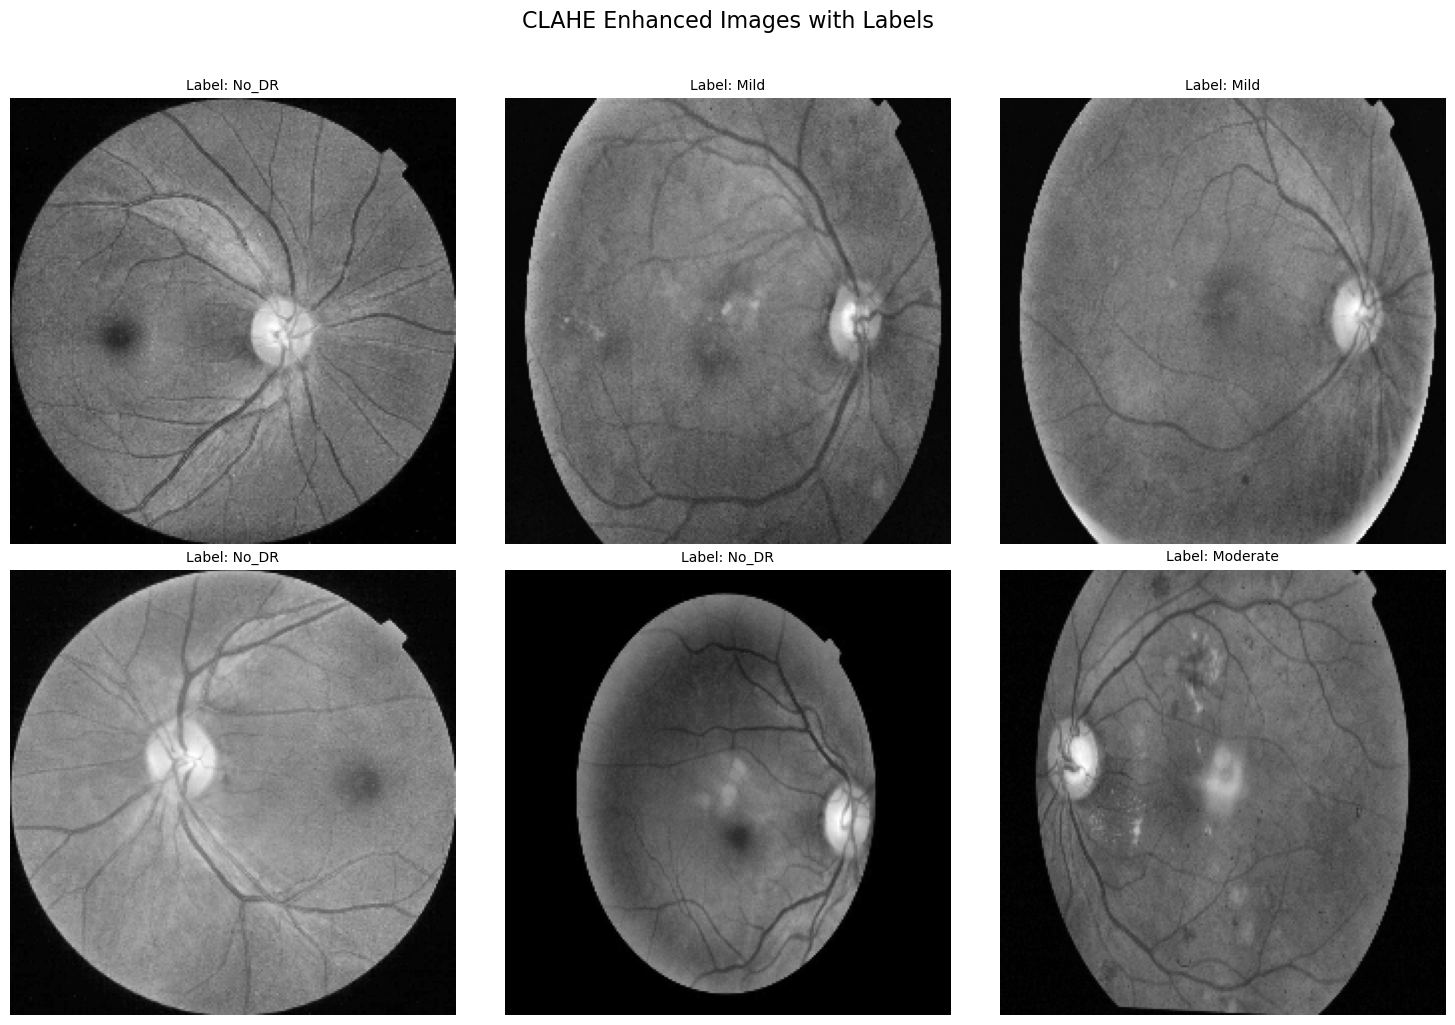

In [7]:
import cv2
# Sample images from a DataFrame (assuming image_df is your DataFrame)
sample_images = image_df.sample(6)

# Apply CLAHE to the sampled images
enhanced_images = [apply_clahe(img_path) for img_path in sample_images['Filepath']]

# Display original and enhanced images
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    # Display the enhanced image
    ax.imshow(enhanced_images[i], cmap='gray')
    
    # Set the title with label information
    title = f"Label: {sample_images['Label'].values[i]}"
    ax.set_title(title, fontsize=10)
    
    # Hide the axis
    ax.axis('off')

# Add a main title to the figure
plt.suptitle('CLAHE Enhanced Images with Labels', fontsize=16, y=1.02)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Apply CLAHE to all images and save them in a new directory
enhanced_image_dir = Path('C:/Users/User/project_final/enhanced_images')
enhanced_image_dir.mkdir(parents=True, exist_ok=True)

for idx, row in image_df.iterrows():
    enhanced_img = apply_clahe(row['Filepath'])
    enhanced_img_path = enhanced_image_dir / Path(row['Filepath']).relative_to(image_dir)
    enhanced_img_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(enhanced_img_path), enhanced_img)

print("CLAHE applied to all images and saved in 'enhanced_images' directory.")

In [8]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [9]:
def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [11]:
models = {
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "DenseNet121": {"model":tf.keras.applications.ResNet101, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.MobileNet, "perf":0}
}

train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 3622 validated image filenames belonging to 5 classes.
Found 402 validated image filenames belonging to 5 classes.
Found 448 validated image filenames belonging to 5 classes.




In [12]:
for name, model in models.items():

    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 504s 4s/step - accuracy: 0.6316 - loss: 0.9961 - val_accuracy: 0.7114 - val_loss: 0.7776
DenseNet169          trained in 509.94 sec
114/114 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.6223 - loss: 1.0107 - val_accuracy: 0.6741 - val_loss: 0.9205
MobileNet            trained in 292.77 sec
114/114 ━━━━━━━━━━━━━━━━━━━━ 481s 4s/step - accuracy: 0.4524 - loss: 1.4024 - val_accuracy: 0.5174 - val_loss: 1.2173
DenseNet121          trained in 484.87 sec
114/114 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.6392 - loss: 0.9669 - val_accuracy: 0.7338 - val_loss: 0.6764
InceptionV3          trained in 301.02 sec


In [13]:
models_result = []

for name, v in models.items():
    models_result.append([ name,
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,train_accuracy,val_accuracy,Training time (sec)
0,InceptionV3,0.7007,0.7338,301.02
1,DenseNet169,0.6949,0.7114,509.94
2,MobileNet,0.6933,0.6741,292.77
3,DenseNet121,0.5030,0.5174,484.87


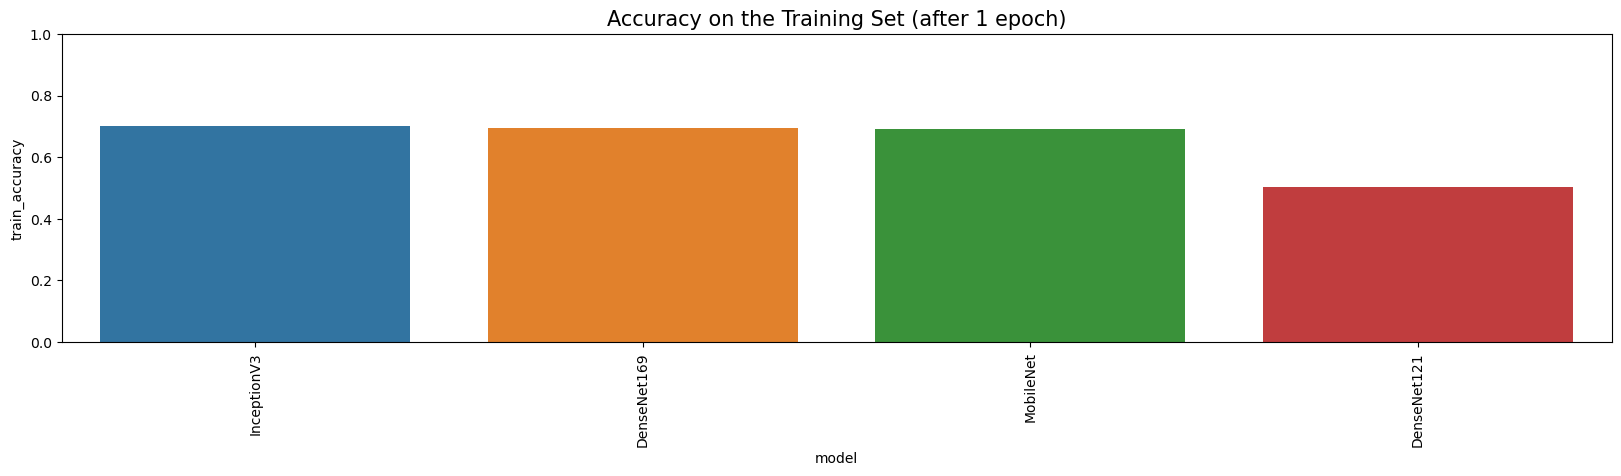

In [14]:
plt.figure(figsize = (20,4))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [15]:
pretrained_model = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False
pretrained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [16]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - AUC: 0.8160 - accuracy: 0.5561 - loss: 1.1836 - val_AUC: 0.8935 - val_accuracy: 0.6294 - val_loss: 0.9384
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - AUC: 0.9317 - accuracy: 0.7209 - loss: 0.7379 - val_AUC: 0.9148 - val_accuracy: 0.6816 - val_loss: 0.8235
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - AUC: 0.9455 - accuracy: 0.7552 - loss: 0.6581 - val_AUC: 0.9221 - val_accuracy: 0.6891 - val_loss: 0.8025
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - AUC: 0.9466 - accuracy: 0.7560 - loss: 0.6489 - val_AUC: 0.9277 - val_accuracy: 0.7239 - val_loss: 0.7547
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - AUC: 0.9584 - accuracy: 0.7832 - loss: 0.5735 - val_AUC: 0.9283 - val_accuracy: 0.7214 - val_loss: 0.7607
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - AUC: 0.9650 - accuracy: 0.7941 - loss: 0.5220 - val_AUC: 0.9288 - val_accuracy: 0.7189 - val_loss: 0.8069


In [17]:
model.save('C:/Users/User/project_final/models/InceptionV3_mod.h5')

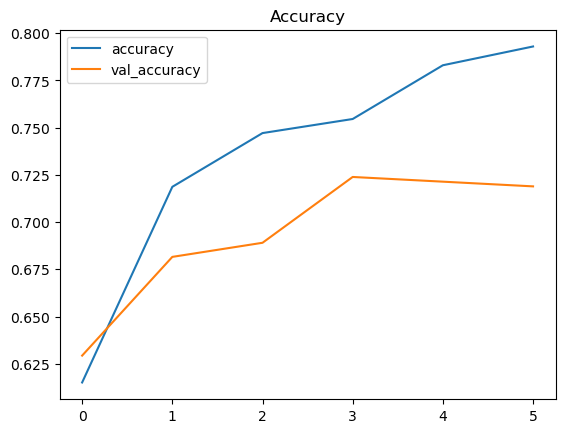

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

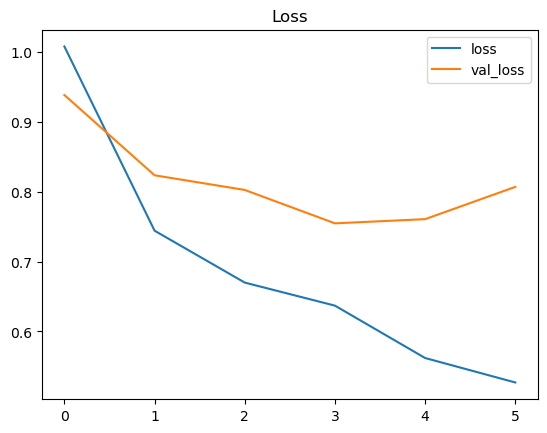

In [19]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [20]:
results = model.evaluate(test_images, verbose=0)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [21]:
printmd("Test Loss: {:.5f}".format(results[0]))
printmd("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.72995

Accuracy on the test set: 73.44%

In [22]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


In [23]:
from sklearn.metrics import classification_report

y_true = test_images.classes 
y_pred = model.predict(test_images)  

y_pred = y_pred.argmax(axis=-1)

class_labels = list(test_images.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)

print(report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step
                precision    recall  f1-score   support

          Mild       0.53      0.24      0.33        38
      Moderate       0.55      0.86      0.67        96
         No_DR       0.93      0.92      0.92       209
Proliferate_DR       0.61      0.41      0.49        54
        Severe       0.64      0.45      0.53        51

      accuracy                           0.73       448
     macro avg       0.65      0.58      0.59       448
  weighted avg       0.74      0.73      0.72       448



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: No_dr
Confidence: 0.9781317114830017


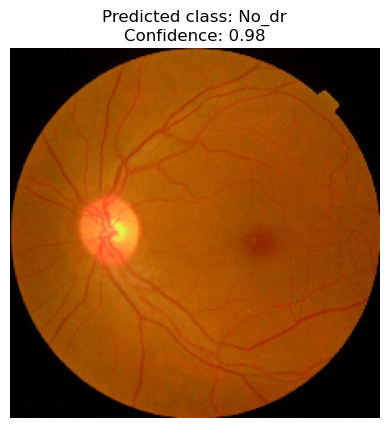

In [26]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project_final/models/InceptionV3_mod.h5") 

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Load and preprocess the input image
image_path = "C:/Users/User/project_final/colored_images/No_DR/00cc2b75cddd.png"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"] 
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Moderate
Confidence: 0.8033366203308105


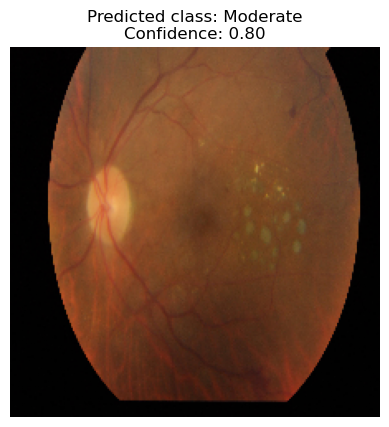

In [27]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project_final/models/InceptionV3_mod.h5") 

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Load and preprocess the input image
image_path = "C:/Users/User/project_final/colored_images//Mild/1d674e2e32e0.png"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class: Severe
Confidence: 0.7386432886123657


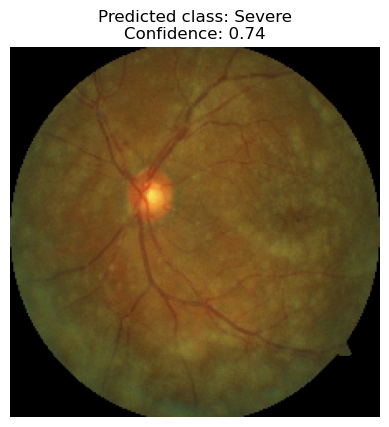

In [4]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project 01/models/DenseNet169.h5") 

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Load and preprocess the input image
image_path = "C:/Users/User/project 01/colored_images/Severe/374.png"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

Test Loss: 0.72995

Accuracy on the test set: 73.44%

14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


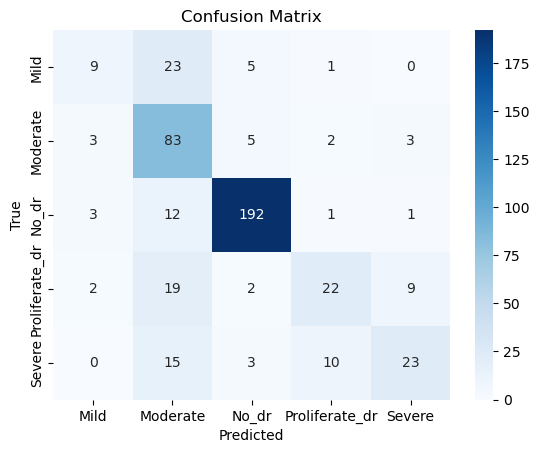

                precision    recall  f1-score   support

          Mild       0.53      0.24      0.33        38
      Moderate       0.55      0.86      0.67        96
         No_dr       0.93      0.92      0.92       209
Proliferate_dr       0.61      0.41      0.49        54
        Severe       0.64      0.45      0.53        51

      accuracy                           0.73       448
     macro avg       0.65      0.58      0.59       448
  weighted avg       0.74      0.73      0.72       448

Precision: 0.6506
Recall: 0.5757
F-score: 0.5875
Support: None
AUC Scores: [0.88356868 0.89248935 0.98078117 0.8644482  0.90709735]


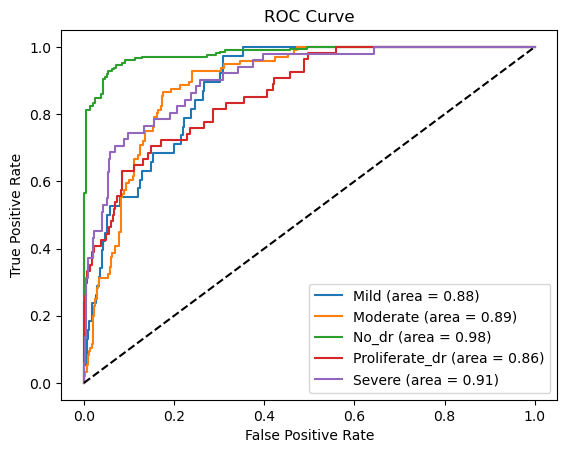

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import cv2
import os
from pathlib import Path
from IPython.display import Image, display, Markdown

def printmd(string):
    display(Markdown(string))

# Existing code to prepare the data, apply CLAHE, and train the models...

# Load the saved model
model = tf.keras.models.load_model('C:/Users/User/project_final/models/InceptionV3_mod.h5')

# Evaluate the model on the test set
results = model.evaluate(test_images, verbose=0)
printmd("Test Loss: {:.5f}".format(results[0]))
printmd("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

# Make predictions on the test set
y_true = test_images.classes
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Calculate precision, recall, f-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred_classes, average='macro')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F-score: {fscore:.4f}')
print(f'Support: {support}')

# Calculate AUC and plot ROC curve
lb = LabelBinarizer()
lb.fit(y_true)
y_true_binarized = lb.transform(y_true)
y_pred_binarized = lb.transform(y_pred_classes)

# Compute AUC for each class
auc_scores = roc_auc_score(y_true_binarized, y_pred, average=None)
print(f'AUC Scores: {auc_scores}')

# Plot ROC curve for each class
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (area = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()